In [1]:
from data_handlers import StockHistDataHandler,ComputeSuite
from trade_env_v0 import trade_env

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
# from tensorflow.keras import layers
from tensorflow import keras 
from scipy.stats import norm, uniform
import tensorflow as tf
import numpy as np
%config Completer.use_jedi = False
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, GRU, TimeDistributed, Input, Masking

from utilities.function_utilities import *

In [3]:
data_handler = StockHistDataHandler()

In [4]:
ts_range = ["2019-01-15","2021-07-5"]
raw_data = data_handler.get_data(sql= """SELECT * from intraday_hist WHERE CAST([eff_date] as time) > CAST('9:30' as time) and CAST([eff_date] as time) < CAST('15:30' as time) order by eff_date asc""")
# _ = ComputeSuite.pct_return(all_data.loc[:,:,:])
raw_data = raw_data.loc[:,["adj_close_price"],:]
train_data = raw_data.values[:,:,~np.isnan(raw_data.values.sum(axis=0)[0])]
train_data = train_data[::-1,:,:] # trading of snapchat

In [5]:

def state_sampler(state_hist_buffer, indices):
    """
    given state history buffer and sample indices, return the data in the model input format
    """
    sampled_time_series = np.concatenate([state_hist_buffer[i][0] for i in indices],axis=0)
    sampled_current = np.concatenate([state_hist_buffer[i][1] for i in indices],axis=0)
    return [sampled_time_series,sampled_current]

def trade_model():
    
    ### timeseries sub_network
    input_layer = keras.layers.Input(shape=(None,5,))
    hidden_layer = keras.layers.GRU(20, activation="tanh",return_sequences = True, name="gru1")(input_layer)
    hidden_layer = keras.layers.GRU(20, activation = "tanh", return_sequences =False, name = "gru2")(hidden_layer)
    output_layer = keras.layers.Dense(2, activation="relu", name ="dense2")(hidden_layer)
    
    
    ### higher level vinalla neural network
    input2 = keras.layers.Input(shape = (3))
    concat = keras.layers.Concatenate()([output_layer, input2])
    h2 = keras.layers.Dense(20,activation = "relu")(concat)
    h2 = keras.layers.Dense(20,activation = "relu")(h2)
    h2 = keras.layers.Dense(20,activation = "relu")(h2)
    h2 = keras.layers.Dense(20,activation = "relu")(h2)
    out2 = keras.layers.Dense(5, activation = "linear")(h2)
     
    model = keras.Model(inputs = [input_layer, input2], outputs = [out2])
    return model


In [6]:




main_model = trade_model()
target_model = trade_model()
loss_function = keras.losses.Huber() #Huber()
# optimizer = keras.optimizers.Adam(learning_rate= 0.0000250,clipnorm=1.0)
# optimizer = keras.optimizers.RMSprop(learning_rate= 0.00015)
# main_model.summary()
# tf.keras.utils.plot_model(
#     main_model, to_file='model.png', show_shapes=True,
#     show_layer_names=True, rankdir='TB', expand_nested=True, dpi=60
# )

start_ep = 10000
num_episode = 100000
update_target = 128
gamma = 1
epi_sode_idx = 0
exploring_state_boundary = 5000 # 1. explore boundary, 2. explore sub optimal
exploring_state_sub_opt = 10000
num_of_action = 5
epsilon = 0.2
prob_of_smaller_interval = 0.3
time_elapsed = 0

oversale_punish = 0.005
reward_curve = []
TWAP = []
model_average = []



# replay_buffer
max_buffer_length = 20000
action_history = []
reward_history = []
state_history = []
state_next_history = []
done_history = []
update_after_action = 4
batch_size = 32
        



# ########## learning rates
# optimizer = keras.optimizers.RMSprop(learning_rate= 0.0001)
# step = tf.Variable(0, trainable=False)
# boundaries = [exploring_state_boundary, exploring_state_sub_opt]
# values = [0.006, 0.003, 0.0002]
# learning_rate_fn = keras.optimizers.schedules.PiecewiseConstantDecay(
#     boundaries, values)
# learning_rate = learning_rate_fn(step)
# optimizer = keras.optimizers.RMSprop(learning_rate= learning_rate)
optimizer = keras.optimizers .Adam(learning_rate= 0.00001,clipnorm=1.0)



# load previous model

In [17]:
previous_model = keras.models.load_model("13k_trace3")
main_model.set_weights(previous_model.get_weights())
target_model.set_weights(previous_model.get_weights())

In [20]:
ep = 10022
random_idx = 1000
env = trade_env(data = train_data[:,:,random_idx+1:]/train_data[:,:,random_idx+20,None])
env.inventory = 100
env.time_remain = 10
state1 = env.start()
main_model.predict(state1)

array([[810.8856 , 710.37836, 615.6319 , 531.71643, 444.48364]],
      dtype=float32)

In [26]:
#### fixed version


print(f"Training from ep {start_ep}")
for ep in range(start_ep, num_episode+start_ep):
    
    
    ######## training cache  ############
    ######################################

    episode_reward = []
    

    ######## load episode data ############
    ######################################
    random_idx = np.random.randint(low=1, high = 160000)
    data_slice =  train_data[:,:,random_idx+1:]/train_data[:,:,random_idx+20,None] # todo: +20 is hard coded to normalize the trade start pric
    max_drawn = np.max(np.abs(np.diff(data_slice[:,0,:33],axis=1).ravel())) 
    if max_drawn>0.005:
        # too volatile or cover two days...
        continue
        
    env = trade_env(data =data_slice)
    
    ######## modify environment for small episode exploration ############
    ######################################################################
    if prob_of_smaller_interval>np.random.rand(1)[0] or ep<exploring_state_boundary:
        
        env.time_remain = np.random.choice([2,3,4])
    else:
        env.time_remain = 10
        
    current_state = env.start()
    is_full_episode = True if env.time_remain ==10 else False
    
    
    ######## exploration-stage and epsilon greedy  ############
    ##########################################################
    while True:
        time_elapsed+=1
        if time_elapsed%update_target ==0:
                target_model.set_weights(main_model.get_weights())
     
        if ep< exploring_state_sub_opt or epsilon>np.random.rand(1)[0]:
            action = np.random.choice(num_of_action)
           
        else:
            action = tf.argmax(main_model(current_state,training = False),axis=1).numpy()[0]
            
           
        
        next_state, reward, end_episode = env.step(action)
        

        
        action_history.append(action)
        reward_history.append(reward)
        state_history.append(current_state)
        state_next_history.append(next_state)
        done_history.append(end_episode)
        episode_reward.append(reward)
        
        ######## train in the experience-replay buffer  ############
        ##########################################################
        
        if  len(action_history)>= batch_size and time_elapsed%update_after_action==0:
        
            indices = np.random.choice(np.arange(len(action_history)),batch_size)
            state_sample = state_sampler(state_history, indices)
            state_next_sample = state_sampler(state_next_history, indices)
            reward_sample = np.array(reward_history)[indices]
            action_sample = np.array(action_history)[indices]
            done_sample = np.array(done_history)[indices]

            future_state_action_val = target_model.predict(state_next_sample)
            future_state_action_val[np.isnan(future_state_action_val)] = 0 # this is for the terminal state (nans)
            future_reward = tf.reduce_max(future_state_action_val,axis=1)
           
            G = reward+gamma*future_reward
            mask = tf.one_hot(action_sample,num_of_action)
          
            
#             print(f"Act pre:{tf.reduce_sum(tf.multiply(main_model(state_sample),mask),axis=1)}")
            with tf.GradientTape() as tape:
                
                current_state_action_val = main_model(state_sample)
                current_reward = tf.reduce_sum(tf.multiply(current_state_action_val,mask),axis=1)
        
                loss = loss_function(G, current_reward)  
                grad = tape.gradient(loss, main_model.trainable_variables)
                optimizer.apply_gradients(zip(grad, main_model.trainable_variables))
#             print(f"Act target:{G}")
#             print(f"Act post:{tf.reduce_sum(tf.multiply(main_model(state_sample),mask),axis=1)}")

                
                
        ######## set_state, clear buffer, and end episode  ############
        ##########################################################     
        current_state = next_state
        if len(action_history)>max_buffer_length:
            del action_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del done_history[:1]
            del reward_history[:1]
        
        
        if end_episode:
            if ep%100 ==0:
                print(ep)
            
            break
 

        
        

Training from ep 0
tf.Tensor(
[  0.      412.05908 607.46356 702.77155 888.7391  876.5939  814.71844
 698.03      0.        0.      507.35437   0.      698.12396 557.4443
 888.7127  619.4642    0.        0.      686.0551  479.11487   0.
 619.4435  288.28455 702.7557  698.08624 226.09573 602.67755   0.
   0.      624.08765   0.      176.1194 ], shape=(32,), dtype=float32)
tf.Tensor(
[478.82672 814.7562  478.46942   0.      524.0954    0.      495.3302
 507.38983 461.81543   0.      910.0109  126.17084 192.80696 507.33685
 624.0185  590.7378    0.      507.48944  73.62148 304.91876   0.
   0.        0.      698.0294  209.45688 624.03906   0.      719.4426
   0.        0.      905.43195 910.15717], shape=(32,), dtype=float32)
tf.Tensor(
[619.2847    0.      781.4449  602.73956 623.9923  271.32886 719.3889
 607.44257 416.76788   0.        0.        0.      893.5368    0.
 221.37572 159.33406 602.70575 669.45496 304.69086 590.9157  702.6586
   0.        0.        0.      607.55927 698.05133

tf.Tensor(
[  0.        0.        0.      280.38287   0.      694.7809  489.87936
 672.28796 614.4016    0.        0.        0.        0.      298.19614
 801.539   707.9984  279.8097  298.19614 770.43445   0.        0.
 316.01477 169.07759 766.0543  677.1013  489.77875   0.      672.5658
 186.8972  578.9137  356.2648  895.16187], shape=(32,), dtype=float32)
tf.Tensor(
[  0.      707.96265 801.49445 895.1356   78.18094 262.54895   0.
   0.        0.      396.50726   0.        0.      485.45877 561.1469
   0.        0.      204.4517  672.49805 503.10794 881.8522  168.94305
 391.97794   0.      690.1477    0.        0.      489.8937  489.87827
 485.3304  409.36215 895.1356    0.     ], shape=(32,), dtype=float32)
tf.Tensor(
[485.11075    0.       596.8058     0.       676.88965  988.7296
   0.         0.       677.1967     0.        78.18094  490.00168
 302.5542   583.4197   690.2464   707.91614  111.150185  78.19381
   0.         0.         0.       801.4259     0.         0.
 485.31213 

KeyboardInterrupt: 

In [ ]:
import seaborn as sns
sns.kdeplot(pnl)
np.mean(pnl)*100

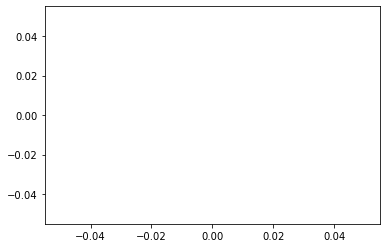

In [10]:
# plt.plot(TWAP)
plt.plot(reward_curve)

In [ ]:
np.mean(model_average)

In [ ]:
np.mean(TWAP)

In [ ]:
# main_model.save("13k_trace3")

In [ ]:
a=1

In [ ]:
len(reward_curve)

In [ ]:
reward_curve = np.array(reward_curve)
r = pd.DataFrame(reward_curve[reward_curve>99.5])

In [ ]:
r.rolling(1500).mean().plot()